# Run mulitple of ML models on GPU with SageMaker Multi-model endpoints

<div class="alert alert-info"> 💡 <strong> Note </strong>
SageMaker Multi-Model Endpoint with GPU support is a beta feature and is not recommended for production use cases
</div>

[Amazon SageMaker](https://aws.amazon.com/sagemaker/) helps data scientists and developers prepare, build, train, and deploy high-quality machine learning (ML) models quickly by bringing together a broad set of capabilities purpose-built for ML. SageMaker accelerates innovation within your organization by providing purpose-built tools for every step of ML development, including labeling, data preparation, feature engineering, statistical bias detection, AutoML, training, tuning, hosting, explainability, monitoring, and workflow automation.

Customers are training ML models to cater individual users, granular market segments, hyper personalized content etc. For example, a call center analytics application using NLP language translation service to serve customers from different geographic location train custom models for different languages. Building large number of custom models can increase the cost of inference and managing models. These challenges become more pronounced when not all models are accessed at the same rate but still need to be available at all times.


This notebook was tested with the `conda_python3` kernel on an Amazon SageMaker notebook instance of type `g5`.

## SageMaker Multi-Model Endpoints with GPU

SageMaker multi-model endpoints(MME) provide a scalable and cost-effective way to deploy large numbers of ML models in the cloud. SageMaker multi-model endpoints enable you to deploy multiple ML models behind a single endpoint and serve them using a single serving container. Today, customers can use MME on CPU based instance types limiting them to deploy deep learning models that need accelerated compute GPUs. With announcement of new private beta feature, customer can host and serve deep learning GPU models using SageMaker multi-model endpoint. 

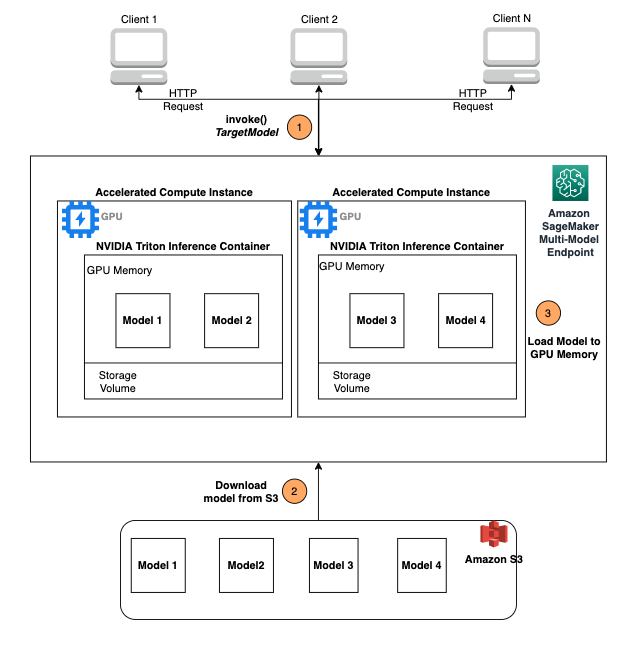

In [1]:
from IPython import display
display.Image("images/mme-gpu1.png")

## Amazon SageMaker Multi-Model endpoints with GPU Support

Amazon SageMaker multi-model endpoints with GPU works with NVIDIA Triton Inference Server (https://github.com/triton-inference-server/server/), which was developed specifically to enable scalable, cost-effective, and easy deployment of models in production. NVIDIA Triton Inference Server is open-source inference serving software that simplifies the inference serving process and provides high inference performance. It has support for multiple frameworks such as TensorFlow GraphDef, TensorFlow SavedModel, ONNX, PyTorch TorchScript, TensorRT, RAPIDS FIL for tree based models, and OpenVINO model formats. Triton has multiple built-in scheduling and batching algorithms that combine individual inference requests together to improve inference throughput.

1. You can invoke a model behind SageMaker MME by specifying the target model in the invocation request. SageMaker manages the lifecycle of the models in MME, routes traffic to the right instance behind the endpoint where the target model is loaded.
2. SageMaker dynamically loads models from Amazon Simple Storage Service(S3) to the instance’s storage volume. Once a model is downloaded onto instance storage volume, SageMaker doesn’t download the model again from S3. If the instance storage volume reaches capacity, SageMaker deletes any unused models from the storage volume.
3. SageMaker loads the model to NVIDIA Triton container memory on GPU enabled instance and serve the inference request. If the model is already loaded in the container memory, the subsequents requests are served faster as SageMaker does not need to download and load it again.
4. SageMaker continues to routes traffics to the instance where the model is loaded. If the instance resources reach capacity due to high utilization,  SageMaker unloads least used models from the container to free up resource to load more frequently used models.
5. Also, SageMaker MME can horizontally scale using auto-scaling policy, provision additional GPU compute instances based on metrics such as GPU utilization, memory utilization etc to serve spiky traffic to MME endpoints.

### Installs

Installs the dependencies required to package the model and run inferences using Triton server. Update SageMaker, boto3, awscli etc

In [3]:
!pip install -qU pip awscli boto3 sagemaker
!pip install nvidia-pyindex --quiet
!pip install tritonclient[http] --quiet
!pip install transformers[sentencepiece] --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.0.1 requires botocore<1.22.9,>=1.22.8, but you have botocore 1.27.96 which is incompatible.


### Imports and variables

In [30]:
import boto3, json, sagemaker, time
from sagemaker import get_execution_role
import numpy as np
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

sm_client = boto3.client(service_name="sagemaker")
runtime_sm_client = boto3.client("sagemaker-runtime")
sagemaker_session = sagemaker.Session(boto_session=boto3.Session())
s3_client = boto3.client('s3')
role = get_execution_role()
bucket = sagemaker.Session().default_bucket()

### Add utility methods for preparing request payload



The `tritonclient` package provides utility methods to generate the payload without having to know the details of the specification. We'll use the following methods to convert our inference request into a binary format which provides lower latencies for inference.

In [5]:
text = "summarize: SageMaker enables customers to deploy a model using custom code with NVIDIA Triton Inference Server. This functionality is available through the development of Triton Inference Server Containers. These containers include NVIDIA Triton Inference Server, support for common ML frameworks, and useful environment variables that let you optimize performance on SageMaker. For a list of all available Deep Learning Containers images, see Available Deep Learning Containers Images. Deep Learning Containers images are maintained and regularly updated with security patches."

In [8]:
text = ["summarize: SageMaker enables customers to deploy a model using custom code with NVIDIA",
        "translate English to German: The house is wonderful."
       ]

In [14]:
def tokenize_text(model_name, text):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenized_text = tokenizer(text, padding="max_length", return_tensors="np")
    return tokenized_text.input_ids, tokenized_text.attention_mask

In [18]:
tokenize_text(bert, text)[0].shape

(2, 512)

In [26]:
import tritonclient.http as httpclient
from transformers import AutoTokenizer
import numpy as np


def tokenize_text(model_name, text):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.model_max_length = 512
    tokenized_text = tokenizer(text, padding="max_length", return_tensors="np")
    return tokenized_text.input_ids, tokenized_text.attention_mask


def get_tokenized_text_binary(model_name, text):
    inputs = []
    outputs = []
    input_ids, attention_mask = tokenize_text(model_name, text)
    inputs.append(httpclient.InferInput("input_ids", input_ids.shape, "INT32"))
    inputs.append(httpclient.InferInput("attention_mask", attention_mask.shape, "INT32"))

    inputs[0].set_data_from_numpy(input_ids.astype(np.int32), binary_data=True)
    inputs[1].set_data_from_numpy(attention_mask.astype(np.int32), binary_data=True)
    
    output_name = "output" if model_name == "t5-small" else "logits"
    outputs.append(httpclient.InferRequestedOutput(output_name, binary_data=True))
    request_body, header_length = httpclient.InferenceServerClient.generate_request_body(
        inputs, outputs=outputs
    )
    return request_body, header_length

In [27]:
bert = "distilbert-base-uncased-finetuned-sst-2-english"
t5 = "t5-small"

### Workflow overview

This section presents overview of main steps for preparing DistilBERT TensorFlow model (served using TensorFlow backend) and T5 Pytorch (served using Python backend) model to be served using Triton Inference Server.

#### 1a. Generate DistilBERT TensorFlow model

First, we use HuggingFace transformers to load pre-trained DistilBERT TensorFlow model that has been fine-tuned for sentiment analysis binary classification task. Then, we save the model as SavedModel serialized format. The `generate_distilbert_tf.sh` bash script performs all these steps inside the NGC TensorFlow container. 

In [29]:
!docker run --gpus=all --ipc=host --ulimit memlock=-1 --ulimit stack=67108864 --rm -it \
            -v `pwd`/workspace:/workspace nvcr.io/nvidia/tensorflow:22.09-tf2-py3 \
            /bin/bash generate_distilbert_tf.sh

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Unable to find image 'nvcr.io/nvidia/tensorflow:22.09-tf2-py3' locally
22.09-tf2-py3: Pulling from nvidia/tensorflow

20708c8b: Pulling fs layer 
25430193: Pulling fs layer 
583c6b12: Pulling fs layer 
be10edc2: Pulling fs layer 
d046b7e1: Pulling fs layer 
e997e3c2: Pulling fs layer 
45bfbc9d: Pulling fs layer 
67d9ff4b: Pulling fs layer 
96db94d9: Pulling fs layer 
aac63bdf: Pulling fs layer 
a652228e: Pulling fs layer 
ec5f9761: Pulling fs layer 
1c09fe21: Pulling fs layer 
b700ef54: Pulling fs layer 
885395bd: Pulling fs layer 
ff9b789b: Pulling fs layer 
aba32b97: Pulling fs layer 
02c3a422: Pulling fs layer 
9aa5441f: Pulling fs layer 
ccfc15f8: Pulling fs layer

#### 1b. T5 Python Backend Model


#### TODO

In [9]:
# !docker run --gpus=all --rm -it \
#             -v `pwd`/workspace:/workspace nvcr.io/nvidia/pytorch:22.07-py3 \
#             /bin/bash generate_model_trt.sh


== PyTorch ==

NVIDIA Release 22.07 (build 40241807)
PyTorch Version 1.13.0a0+08820cb

Container image Copyright (c) 2022, NVIDIA CORPORATION & AFFILIATES. All rights reserved.

Copyright (c) 2014-2022 Facebook Inc.
Copyright (c) 2011-2014 Idiap Research Institute (Ronan Collobert)
Copyright (c) 2012-2014 Deepmind Technologies    (Koray Kavukcuoglu)
Copyright (c) 2011-2012 NEC Laboratories America (Koray Kavukcuoglu)
Copyright (c) 2011-2013 NYU                      (Clement Farabet)
Copyright (c) 2006-2010 NEC Laboratories America (Ronan Collobert, Leon Bottou, Iain Melvin, Jason Weston)
Copyright (c) 2006      Idiap Research Institute (Samy Bengio)
Copyright (c) 2001-2004 Idiap Research Institute (Ronan Collobert, Samy Bengio, Johnny Mariethoz)
Copyright (c) 2015      Google Inc.
Copyright (c) 2015      Yangqing Jia
Copyright (c) 2013-2016 The Caffe contributors
All rights reserved.

Various files include modifications (c) NVIDIA CORPORATION & AFFILIATES.  All rights reserved.

This 

#### 2. Build Model Respository

The first step in using Triton to serve the TODO is to place the models into a [model repository](https://github.com/triton-inference-server/server/blob/main/docs/user_guide/model_repository.md). We use config.pbtxt file to specify [model configuration](https://github.com/triton-inference-server/server/blob/main/docs/model_configuration.md) which Triton uses to load the model. 
The model repository contains model to serve, in our case it will be the model.savedmodel and model.py and configuration file with input/output specifications and metadata.


#### DistilBERT TensorFlow Model

Model repository structure for DistilBERT TensorFlow Model.

```
distilbert_tf
├── 1
│   └── model.savedmodel
└── config.pbtxt
```

Model configuration must specify the platform and backend properties, max_batch_sixze property and the input and output tensors of the model. Additionally, you can specify instance_group and dynamic_batching properties for optimal inference performance in terms of latency and concurrency.

In [10]:
!mkdir -p triton-serve-tf/distilbert_tf/

In [11]:
%%writefile triton-serve-tf/distilbert_tf/config.pbtxt
name: "distilbert_tf"
platform: "tensorflow_savedmodel"
max_batch_size: 128
input: [
    {
        name: "input_ids"
        data_type: TYPE_INT32
        dims: [ -1 ]
    },
    {
        name: "attention_mask"
        data_type: TYPE_INT32
        dims: [ -1 ]
    }
]
output: [
    {
        name: "logits"
        data_type: TYPE_FP32
        dims: [ 2 ]
    }
]
instance_group {
  count: 1
  kind: KIND_GPU
}
dynamic_batching {
  preferred_batch_size: 16 # TODO
}

Overwriting triton-serve-pt/efficientnet_b7/config.pbtxt


#### T5 Python Backend Model

Model repository structure for T5 Model.

```
t5
├── 1
│   └── model.py
└── config.pbtxt
```


### TODO

#### 3. Export model artifacts to S3

SageMaker expects the model artifacts in below format, it should also satisfy Triton container requirements such as model name, version, config.pbtxt files etc. `tar` the folder containing the model file as `model.tar.gz` and upload it to s3

In [14]:
!mkdir -p triton-serve-tf/distilbert_tf/1/
!mv -f workspace/hf_distilbert/saved_model/1 workspace/hf_distilbert/model.savedmodel
!mv -f workspace/hf_distilbert/model.savedmodel triton-serve-tf/distilbert_tf/1/
!tar -C triton-serve-tf/ -czf distilbert_tf.tar.gz distilbert_tf
model_uri_tf = sagemaker_session.upload_data(path="distilbert_tf.tar.gz", key_prefix=prefix)

#### TODO

#### 4. Creating copies of model to be loaded to MME

We will create 4 copies of the resnet50 model to be used with SageMaker multi-model endpoint(MME). In practice, this could be 1000s of custom model depending on ML application and use case.

In [20]:
!aws s3 cp s3://{bucket}/{prefix}/efficientnet_b7_pt_v0.tar.gz s3://{bucket}/{prefix}/efficientnet_b7_pt_v1.tar.gz
!aws s3 cp s3://{bucket}/{prefix}/efficientnet_b7_trt_v0.tar.gz s3://{bucket}/{prefix}/efficientnet_b7_trt_v1.tar.gz

copy: s3://sagemaker-ap-south-1-917092859813/efficientnet_b7_mme_gpu/efficientnet_b7_pt_v0.tar.gz to s3://sagemaker-ap-south-1-917092859813/efficientnet_b7_mme_gpu/efficientnet_b7_pt_v1.tar.gz
copy: s3://sagemaker-ap-south-1-917092859813/efficientnet_b7_mme_gpu/efficientnet_b7_trt_v0.tar.gz to s3://sagemaker-ap-south-1-917092859813/efficientnet_b7_mme_gpu/efficientnet_b7_trt_v1.tar.gz


#### 5. Create SageMaker Endpoint

Now that we have 4 models, we start off by creating a [sagemaker model](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateModel.html) from the model files we uploaded to s3 in the previous step.

In this step we also provide an additional Environment Variable i.e. `SAGEMAKER_TRITON_DEFAULT_MODEL_NAME` which specifies the name of the model to be loaded by Triton. **The value of this key should match the folder name in the model package uploaded to s3**. This variable is optional in case of a single model. In case of ensemble models, this key **has to be** specified for Triton to startup in SageMaker.

Additionally, customers can set `SAGEMAKER_TRITON_BUFFER_MANAGER_THREAD_COUNT` and `SAGEMAKER_TRITON_THREAD_COUNT` for optimizing the thread counts.

<div class="alert alert-info"> 💡 <strong> Note </strong>
Update messaging on latest Triton image. Also, include steps to replicate to customer account in any region.
</div>

`model_data_url` is the S3 directory that contains all the models that SageMaker mulit-model endpoint will use to load  and serve predictions. `Mode` indicated the mode in which SageMaker would host this model - `MultiModel`

In [22]:
!aws s3 ls s3://{bucket}/{prefix}/

2022-08-19 03:48:08 1244003900 bert_pt_v1.tar.gz
2022-08-19 03:48:12 1177991632 bert_trt_v1.tar.gz
2022-10-04 15:14:31   19879102 efficientnet_b7_pt_v0.tar.gz
2022-10-04 15:16:27   19879102 efficientnet_b7_pt_v1.tar.gz
2022-08-19 03:00:23  244970253 efficientnet_b7_pt_v10.tar.gz
2022-08-19 03:00:25  244970253 efficientnet_b7_pt_v11.tar.gz
2022-08-19 03:00:26  244970253 efficientnet_b7_pt_v12.tar.gz
2022-08-19 03:00:27  244970253 efficientnet_b7_pt_v13.tar.gz
2022-08-19 03:00:28  244970253 efficientnet_b7_pt_v14.tar.gz
2022-08-19 03:00:29  244970253 efficientnet_b7_pt_v15.tar.gz
2022-08-19 03:00:31  244970253 efficientnet_b7_pt_v16.tar.gz
2022-08-19 03:00:32  244970253 efficientnet_b7_pt_v17.tar.gz
2022-08-19 03:00:34  244970253 efficientnet_b7_pt_v18.tar.gz
2022-08-19 03:00:35  244970253 efficientnet_b7_pt_v19.tar.gz
2022-08-19 03:00:13  244970253 efficientnet_b7_pt_v2.tar.gz
2022-08-19 03:00:36  244970253 efficientnet_b7_pt_v20.tar.gz
2022-08-19 03:00:37  244970253 efficientnet_b7_pt_

In [23]:
mme_triton_image_uri = "850464037171.dkr.ecr.ap-south-1.amazonaws.com/tritonserver:22.07-py3"

model_data_url = f"s3://{bucket}/{prefix}/"

container = {
    "Image": mme_triton_image_uri,
    "ModelDataUrl": model_data_url,
    "Mode": "MultiModel",
    "Environment": {"SAGEMAKER_TRITON_DEFAULT_MODEL_NAME": "efficientnet_b7"},
}

Once the image, data location are set we create the model using `create_model` by specifying the `ModelName` and the Container definition

In [24]:
sm_model_name = "efficientnet-b7-mme-gpu-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

create_model_response = sm_client.create_model(
    ModelName=sm_model_name, ExecutionRoleArn=role, PrimaryContainer=container
)

print("Model Arn: " + create_model_response["ModelArn"])

Model Arn: arn:aws:sagemaker:ap-south-1:917092859813:model/efficientnet-b7-mme-gpu-2022-10-04-15-18-53


Using the model above, we create an [endpoint configuration](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateEndpointConfig.html) where we can specify the type and number of instances we want in the endpoint.

In [27]:
endpoint_config_name = "efficientnet-b7-mme-gpu-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.g4dn.2xlarge",
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

Endpoint Config Arn: arn:aws:sagemaker:ap-south-1:917092859813:endpoint-config/efficientnet-b7-mme-gpu-2022-10-04-15-19-41


Using the above endpoint configuration we create a new sagemaker endpoint and wait for the deployment to finish. The status will change to **InService** once the deployment is successful.

In [28]:
endpoint_name = "efficientnet-b7-mme-gpu-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

Endpoint Arn: arn:aws:sagemaker:ap-south-1:917092859813:endpoint/efficientnet-b7-mme-gpu-2022-10-04-15-19-42


In [29]:
resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:ap-south-1:917092859813:endpoint/efficientnet-b7-mme-gpu-2022-10-04-15-19-42
Status: InService


In [30]:
# Perform auto-scaling of the endpoint based on GPU memory utilization

import boto3
from sagemaker import get_execution_role
import sagemaker

# Define application auto-scaling client
# Common class representing Application Auto Scaling for SageMaker amongst other AWS services
auto_scaling_client = boto3.client('application-autoscaling')

# This is the format in which application autoscaling references the endpoint
resource_id='endpoint/' + endpoint_name + '/variant/' + 'AllTraffic' 
response = auto_scaling_client.register_scalable_target(
    ServiceNamespace='sagemaker',
    ResourceId=resource_id,
    ScalableDimension='sagemaker:variant:DesiredInstanceCount',
    MinCapacity=1,
    MaxCapacity=5
)


# GPUMemoryUtilization metric
response = auto_scaling_client.put_scaling_policy(
    PolicyName='GPUMemoryUtil-ScalingPolicy',
    ServiceNamespace='sagemaker',
    ResourceId=resource_id,
    ScalableDimension='sagemaker:variant:DesiredInstanceCount', # SageMaker supports only Instance Count
    PolicyType='TargetTrackingScaling', # 'StepScaling'|'TargetTrackingScaling'
    TargetTrackingScalingPolicyConfiguration={
        # Scale out when GPU Memory utilization hits GPUMemoryUtilization target value.
        'TargetValue': 60.0, 
        'CustomizedMetricSpecification':
        {
            'MetricName': 'GPUMemoryUtilization',
            'Namespace': '/aws/sagemaker/Endpoints',
            'Dimensions': [
                {'Name': 'EndpointName', 'Value': endpoint_name },
                {'Name': 'VariantName','Value': 'AllTraffic'}
            ],
            'Statistic': 'Average', # Possible - 'Statistic': 'Average'|'Minimum'|'Maximum'|'SampleCount'|'Sum'
            'Unit': 'Percent'
        },
        'ScaleInCooldown': 600,
        'ScaleOutCooldown': 200 
    }
)

#### 7. Run Inference

#### TensorRT model

In [31]:
trt_payload = {
    "inputs": [
        {"name": "input", "shape": [1, 3, 224, 224], "datatype": "FP32", "data": get_sample_image()}
    ]
}

response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_name, ContentType="application/octet-stream", Body=json.dumps(trt_payload),
    TargetModel='efficientnet_b7_trt_v0.tar.gz'
)

print(json.loads(response["Body"].read().decode("utf8")))

{'model_name': 'c06f6775c97edab0960722da53fc3359', 'model_version': '1', 'outputs': [{'name': 'output', 'datatype': 'FP32', 'shape': [1, 1000], 'data': [0.241455078125, 0.43359375, 0.60400390625, -0.477294921875, -0.415283203125, 1.015625, -0.2548828125, -0.3017578125, -0.31640625, -0.479736328125, 0.9453125, 0.98486328125, 0.355224609375, 0.19287109375, 1.6982421875, 0.1939697265625, 0.66064453125, 0.92333984375, 0.30126953125, -0.164306640625, -0.342529296875, -0.84619140625, -0.0057373046875, -0.3037109375, -0.5390625, 0.89501953125, 0.08465576171875, 0.55615234375, 0.77587890625, 0.057525634765625, -0.06787109375, 0.46533203125, -0.303955078125, -0.83349609375, -0.350341796875, -1.2353515625, -0.06982421875, -0.609375, 0.759765625, -1.1884765625, 1.5615234375, 0.31494140625, 0.1405029296875, 0.42236328125, -0.376953125, -0.37841796875, -0.37841796875, 0.03759765625, -0.42431640625, 0.242431640625, -0.259033203125, -1.7802734375, -0.466796875, -0.484619140625, 0.9267578125, 0.490966

#### PyTorch Model

In [32]:
pt_payload = {
    "inputs": [
        {
            "name": "INPUT__0",
            "shape": [1, 3, 224, 224],
            "datatype": "FP32",
            "data": get_sample_image(),
        }
    ]
}

response = runtime_sm_client.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="application/octet-stream",
            Body=json.dumps(pt_payload),
            TargetModel='efficientnet_b7_pt_v0.tar.gz', 
        )

response = json.loads(response["Body"].read().decode("utf8"))
output = response['outputs'][0]['data']

print(f"Model name - {response['model_name']}")
print(f"Ouput - {output}")

Model name - e77d751d3e83c05b3321292a6f59b732
Ouput - [0.24254490435123444, 0.43710166215896606, 0.6078185439109802, -0.4756697714328766, -0.4048377275466919, 1.0159721374511719, -0.26100823283195496, -0.3075311779975891, -0.31600743532180786, -0.47820645570755005, 0.9386941194534302, 0.9843425750732422, 0.35071611404418945, 0.19242379069328308, 1.6932399272918701, 0.19534845650196075, 0.6575428247451782, 0.9280214309692383, 0.3023480772972107, -0.16451168060302734, -0.35185205936431885, -0.8419138193130493, -0.009049341082572937, -0.3015584945678711, -0.5398705005645752, 0.892857015132904, 0.08421388268470764, 0.5567072629928589, 0.7704562544822693, 0.0603572353720665, -0.062082439661026, 0.46968740224838257, -0.30095410346984863, -0.8347076177597046, -0.3541741371154785, -1.2346746921539307, -0.06757596880197525, -0.6087387800216675, 0.7586485147476196, -1.1867456436157227, 1.5610474348068237, 0.3106628656387329, 0.13729146122932434, 0.41757428646087646, -0.3755865693092346, -0.37940

We can also use binary+json as the payload format to get better performance for the inference call. The specification of this format is provided [here](https://github.com/triton-inference-server/server/blob/main/docs/protocol/extension_binary_data.md).

**Note:** With the `binary+json` format, we have to specify the length of the request metadata in the header to allow Triton to correctly parse the binary payload. This is done using a custom Content-Type header `application/vnd.sagemaker-triton.binary+json;json-header-size={}`.

Please not, this is different from using `Inference-Header-Content-Length` header on a stand-alone Triton server since custom headers are not allowed in SageMaker.

In [33]:
request_body, header_length = get_sample_image_binary_pt()

response = runtime_sm_client.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="application/vnd.sagemaker-triton.binary+json;json-header-size={}".format(header_length),
            Body=request_body,
            TargetModel='efficientnet_b7_pt_v1.tar.gz', 
        )

# Parse json header size length from the response
header_length_prefix = "application/vnd.sagemaker-triton.binary+json;json-header-size="
header_length_str = response["ContentType"][len(header_length_prefix) :]

# Read response body
result = httpclient.InferenceServerClient.parse_response_body(
    response["Body"].read(), header_length=int(header_length_str)
)
output0_data = result.as_numpy("OUTPUT__0")
print(output0_data)

[[ 2.42544904e-01  4.37101662e-01  6.07818544e-01 -4.75669771e-01
  -4.04837728e-01  1.01597214e+00 -2.61008233e-01 -3.07531178e-01
  -3.16007435e-01 -4.78206456e-01  9.38694119e-01  9.84342575e-01
   3.50716114e-01  1.92423791e-01  1.69323993e+00  1.95348457e-01
   6.57542825e-01  9.28021431e-01  3.02348077e-01 -1.64511681e-01
  -3.51852059e-01 -8.41913819e-01 -9.04934108e-03 -3.01558495e-01
  -5.39870501e-01  8.92857015e-01  8.42138827e-02  5.56707263e-01
   7.70456254e-01  6.03572354e-02 -6.20824397e-02  4.69687402e-01
  -3.00954103e-01 -8.34707618e-01 -3.54174137e-01 -1.23467469e+00
  -6.75759688e-02 -6.08738780e-01  7.58648515e-01 -1.18674564e+00
   1.56104743e+00  3.10662866e-01  1.37291461e-01  4.17574286e-01
  -3.75586569e-01 -3.79404068e-01 -3.75976324e-01  3.68158221e-02
  -4.22802031e-01  2.36565083e-01 -2.55912632e-01 -1.78508890e+00
  -4.62750465e-01 -4.81936812e-01  9.27686036e-01  4.99455661e-01
  -1.14785165e-01  9.38045561e-01 -4.08673704e-01  6.85431883e-02
   5.81793

Refer below cells to make additional copy of model artifacts in S3. 

In [35]:
import random
import time

for i in range(10):
    n = random.randint(0,1)
    
    print(f"Running EfficientNet Model:efficientnet_b7_pt_v{n}.tar.gz" )

    response = runtime_sm_client.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="application/octet-stream",
            Body=json.dumps(pt_payload),
            TargetModel=f"efficientnet_b7_pt_v{n}.tar.gz"
        )
    response = json.loads(response["Body"].read().decode("utf8"))
    output = response['outputs'][0]['data']
    time.sleep(3)
    #print(output)

Running EfficientNet Model:efficientnet_b7_pt_v1.tar.gz
Running EfficientNet Model:efficientnet_b7_pt_v0.tar.gz
Running EfficientNet Model:efficientnet_b7_pt_v1.tar.gz
Running EfficientNet Model:efficientnet_b7_pt_v0.tar.gz
Running EfficientNet Model:efficientnet_b7_pt_v1.tar.gz
Running EfficientNet Model:efficientnet_b7_pt_v0.tar.gz
Running EfficientNet Model:efficientnet_b7_pt_v1.tar.gz
Running EfficientNet Model:efficientnet_b7_pt_v1.tar.gz
Running EfficientNet Model:efficientnet_b7_pt_v1.tar.gz
Running EfficientNet Model:efficientnet_b7_pt_v0.tar.gz


Refer below cells to make additional copy of model artifacts in S3. 

In [37]:
import random

for i in range(10):
    n = random.randint(0,1)
    
    print(f"Running EfficientNet Model:efficientnet_b7_trt_v{n}.tar.gz" )

    response = runtime_sm_client.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="application/octet-stream",
            Body=json.dumps(trt_payload),
            TargetModel=f"efficientnet_b7_trt_v{n}.tar.gz"
        )
    response = json.loads(response["Body"].read().decode("utf8"))
    output = response['outputs'][0]['data']
    #print(output)

Running EfficientNet Model:efficientnet_b7_trt_v1.tar.gz
Running EfficientNet Model:efficientnet_b7_trt_v1.tar.gz
Running EfficientNet Model:efficientnet_b7_trt_v1.tar.gz
Running EfficientNet Model:efficientnet_b7_trt_v1.tar.gz
Running EfficientNet Model:efficientnet_b7_trt_v0.tar.gz
Running EfficientNet Model:efficientnet_b7_trt_v0.tar.gz
Running EfficientNet Model:efficientnet_b7_trt_v0.tar.gz
Running EfficientNet Model:efficientnet_b7_trt_v1.tar.gz
Running EfficientNet Model:efficientnet_b7_trt_v0.tar.gz
Running EfficientNet Model:efficientnet_b7_trt_v0.tar.gz


#### Terminate endpoint and clean up artifacts

In [ ]:
sm_client.delete_model(ModelName=sm_model_name)
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
sm_client.delete_endpoint(EndpointName=endpoint_name)